In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# To sample the diffusion-weighted directions
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere

# To reconstruct the tables with the acquisition information
from dipy.core.gradients import gradient_table

# To perform the monte-carlo simulations
from dipy.sims.voxel import multi_tensor

# To process the diffusion tensor
import dipy.reconst.dti as dti

# Importing procedures to fit the free water elimination DTI model
from dipy.reconst.fwdti import (wls_fit_tensor, nlls_fit_tensor)

In [48]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

# Sample 32 diffusion-weighted directions
n_pts = 32
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions = hsph_updated.vertices # directions for each shell

# Parameters of the 7x12 full acquisitions
# (6 b-values = 0, 32 directions for each b-values 500 and 1500)
bvecs = np.vstack((np.zeros((6, 3)), directions, directions))
bmin = np.linspace(200, 800, num=7)
bmax = np.linspace(300, 1500, num=13)

# SNR should be described as function of bmax
SNR = 15.0
T2 = 70.0
TE = np.array([64.0, 65.0, 66.0, 68.0, 69.0, 70.0, 71.0,
               71.0, 72.0, 73.0, 74.0, 75.0, 75.0])
sf = 1. / np.exp(-TE[7]/T2)

In [49]:
# ---------------------------------------------------------------
# Ground truth values of tissue's diffusion tensor and
# water volume fraction
# ---------------------------------------------------------------

FA = 0.712
L1 = 1.6e-3 
L2 = 0.5e-3
L3 = 0.3e-3
F = 0.50
TRACE = 2.4e-3
Dwater = 3e-3

mevals = np.array([[L1, L2, L3], [Dwater, Dwater, Dwater]])
fractions = [100 - F*100, F*100]

# ---------------------------------------------------------------
# Generate simulations
# ---------------------------------------------------------------

bvals = np.hstack((np.zeros(6), 500 * np.ones(n_pts),
                   1500 * np.ones(n_pts)))


nrep = 100  # number of simulation repetitions
DWI_simulates = np.zeros((bmin.size, bmax.size, nrep, bvecs.shape[0]))

for bmax_i in range(bmax.size):
    # Adjust SNR
    SNRa = SNR * sf * np.exp(-TE[bmax_i]/T2)
    for bmin_i in range(bmin.size):
        # Generate a specific acquisition table
        bvals = np.hstack((np.zeros(6), bmin[bmin_i]*np.ones(n_pts),
                           bmax[bmax_i]*np.ones(n_pts)))
        gtab = gradient_table(bvals, bvecs)
        design_matrix = dti.design_matrix(gtab)
        if bmax_i > bmin_i:
            for s_i in range(nrep):
                signal, sticks = multi_tensor(gtab, mevals, S0=100,
                                              angles=[(0, 0), (0, 0)],
                                              fractions=fractions, snr=SNRa)
                DWI_simulates[bmin_i, bmax_i, s_i, :] = signal 

In [50]:
# ---------------------------------------------------------------
# fit the free water elimination DTI model
# ---------------------------------------------------------------

# WLLS procedures is used to estimate parameters initial guess
fw_params_initial = wls_fit_tensor(design_matrix, DWI_simulates,
                                   Diso=Dwater,
                                   S0=np.mean(DWI_simulates[:, :, :, bvals==0], axis=3))

fw_params = fw_params_initial.copy()

In [42]:
# NLLS procedures is used to find final parameters guess
fw_params = nlls_fit_tensor(design_matrix, DWI_simulates, 
                            fw_params=fw_params, Diso=Dwater, cholesky=True, f_transform=True)

C:\Users\Rafael\dipy\dipy\reconst\fwdti.py:559: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if fw_params==None:


ValueError: The data in this voxel contains only zeros

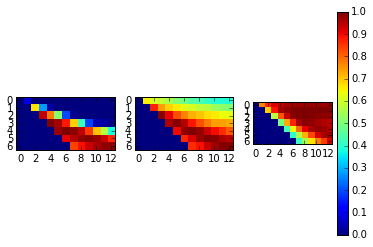

In [51]:
# ---------------------------------------------------------------
# Process diffusion tensor standard measures and plot
# ---------------------------------------------------------------

evals = fw_params[..., :3]

f = fw_params[..., 12]
fa = dti.fractional_anisotropy(evals)
trace = np.sum(evals, axis=3)

df2 = np.square(f - F)
dfa2 = np.square(fa - FA)
dtrace2 = np.square(trace - TRACE)

msef = np.sum(df2, axis=2) / nrep
msefa = np.sum(dfa2, axis=2) / nrep
msetrace = np.sum(dtrace2, axis=2) / nrep

# Reciprocal scaled
msef = 1 - (msef-np.min(msef)) / (np.max(msef)-np.min(msef))
msefa = 1 - (msefa-np.min(msefa)) / (np.max(msefa)-np.min(msefa))
msetrace = 1 - (msetrace-np.min(msetrace)) / (np.max(msetrace)-np.min(msetrace))

fig, axs = plt.subplots(nrows=1, ncols=3)
axs[0].imshow(msef, interpolation="nearest")
axs[1].imshow(msefa, interpolation="nearest")
im = axs[2].imshow(msetrace, interpolation="nearest")
fig.colorbar(im)
plt.show()